In [1]:
import json
import os
import pandas as pd
import seaborn as sns
import numpy as np

from util.config import versioned

In [2]:
matched_all = versioned.read_parquet("matched.parquet")
matched_all = matched_all[matched_all["overall_score"] > 10.5]
def drop_duplicates(df, *cols):
    for col in cols:
        df = df[(~df[col].duplicated()) | df[col].isna()]
    return df.reset_index(drop=True)
matched_all = drop_duplicates(matched_all, "krs_name", "pkw_name", "wiki_name")
matched_all

,mistake_odds,unique_chance,overall_score,koryta_name,krs_name,pkw_name,wiki_name,birth_year,birth_date,employment,...,first_name_13,count_14,p_15,last_name_16,count_17,teryt,wiki_name_1,is_polityk_1,wiki_score,koryta_name_1
0,9.007199e+15,1.0,14.000000,None,Krzysztof Stanisław Planeta,Planeta Krzysztof Stanisław,None,1950,1950-05-11,"[{'employed_end': 2005-05-11, 'employed_for': ...",...,stanisław,2,4.556722e-08,planeta,3.0,14,None,None,NaN,None
1,9.007199e+15,1.0,14.000000,None,Krzysztof Stanisław Tronczyński,TRONCZYŃSKI Krzysztof Stanisław,None,1952,1952-05-08,"[{'employed_end': 2013-10-30, 'employed_for': ...",...,stanisław,2,4.556722e-08,tronczyński,3.0,10,None,None,NaN,None
2,9.007199e+15,1.0,14.000000,None,Stanisław Edward Jędrusina,Jędrusina Stanisław Edward,None,1960,1960-05-25,"[{'employed_end': 2007-04-25, 'employed_for': ...",...,edward,2,4.556722e-08,jędrusina,3.0,06,None,None,NaN,None
3,9.007199e+15,1.0,12.000000,None,Krzysztof Edward Derbiszewski,Derbiszewski Krzysztof Edward,None,1965,1965-02-08,"[{'employed_end': 2006-08-22, 'employed_for': ...",...,edward,2,4.556722e-08,derbiszewski,2.0,32,None,None,NaN,None
4,4.503600e+15,1.0,14.000000,None,Damian Tomasz Fierla,Fierla Damian Tomasz,None,1964,1964-07-25,"[{'employed_end': 2020-02-20, 'employed_for': ...",...,tomasz,2,4.556722e-08,fierla,2.5,24,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8182,NaN,NaN,10.785398,None,Kazimierz Dziok,None,Kazimierz Dziok,1941,1941-08-14,"[{'employed_end': 2006-07-05, 'employed_for': ...",...,None,<NA>,NaN,None,NaN,None,Kazimierz Dziok,None,0.785398,None
8183,NaN,NaN,10.785398,None,Marian Robełek,None,Marian Robełek,1943,1943-04-18,"[{'employed_end': 2007-04-13, 'employed_for': ...",...,None,<NA>,NaN,None,NaN,None,Marian Robełek,None,0.785398,None
8184,NaN,NaN,10.785398,None,Mieczysław Bieniek,None,Mieczysław Bieniek,1951,1951-06-19,"[{'employed_end': 2014-07-07, 'employed_for': ...",...,None,<NA>,NaN,None,NaN,None,Mieczysław Bieniek,None,0.785398,None
8185,NaN,NaN,10.785398,None,Roman Iwaszkiewicz,None,Roman Tadeusz Iwaszkiewicz,1950,1950-01-12,"[{'employed_end': 2005-01-03, 'employed_for': ...",...,None,<NA>,NaN,None,NaN,None,Roman Tadeusz Iwaszkiewicz,None,0.785398,None


In [3]:
people_krs = pd.DataFrame(versioned.read_jsonl("people_krs.jsonl"))
people_krs

,id,first_name,last_name,full_name,employed_krs,employed_end,employed_for,birth_date,second_names,sex
0,1219062,Dariusz,Kwiatkowski,Dariusz Jakub Kwiatkowski,0000002251,2025-10-26,0.13,1984-05-22,Jakub,M
1,1401777,Jakub,Ufnal,Jakub Cezary Ufnal,0000002251,2025-10-26,12.27,1985-05-01,Cezary,M
2,413693,Ireneusz,Zdun,Ireneusz Adam Zdun,0000002251,2025-10-26,22.92,1961-12-23,Adam,M
3,413692,Marek,Łach,Marek Andrzej Łach,0000002251,2025-10-26,22.92,1961-12-10,Andrzej,M
4,413694,Bogusław,Kopeć,Bogusław Adam Kopeć,0000002251,2025-10-26,22.92,1964-04-06,Adam,M
...,...,...,...,...,...,...,...,...,...,...
60726,856190,Agnieszka,Leszczyńska,Agnieszka Leszczyńska,0001052606,2025-05-22,1.78,1972-11-15,None,F
60727,3145092,Krzysztof,Pierzchała,Krzysztof Zdzisław Pierzchała,0001052606,2025-05-22,1.78,1985-07-06,Zdzisław,M
60728,793659,Aleksander,Wójcik,Aleksander Wójcik,0001052606,2025-05-22,1.78,1978-09-24,None,M
60729,1071172,Artur,Paszko,Artur Zygmunt Paszko,0001052606,2025-02-18,1.53,1971-02-21,Zygmunt,M


In [4]:
people_pkw = pd.DataFrame(versioned.read_jsonl("people_pkw.jsonl"))
people_pkw

,election_year,sex,birth_year,age,teryt_candidacy,teryt_living,candidacy_success,party,position,pkw_name,first_name,middle_name,last_name,party_member
0,2010,F,1976.0,34,020000,026401,FALSE,KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ,None,Hajdasz Ewa,Ewa,None,Hajdasz,None
1,2010,M,1982.0,28,020000,026401,FALSE,KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ,None,Konieczny Wojciech Jacek,Wojciech,Jacek,Konieczny,None
2,2010,M,1958.0,52,020000,026401,FALSE,KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ,None,Konik Mieczysław Jerzy,Mieczysław,Jerzy,Konik,None
3,2010,F,1978.0,32,020000,026401,FALSE,KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ,None,Kowol-Stachowiak Agnieszka Marta,Agnieszka,Marta,Kowol-Stachowiak,None
4,2010,F,1991.0,19,020000,026401,FALSE,KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ,None,Krawiec Karolina Barbara,Karolina,Barbara,Krawiec,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911918,1994,M,1928.0,66,9775795,None,None,None,None,Burczyński Zygmunt,Zygmunt,None,Burczyński,None
1911919,1994,F,1960.0,34,9775795,None,None,None,None,Czereda Stanisława,Stanisława,None,Czereda,None
1911920,1994,M,1951.0,43,9775795,None,None,None,None,Marciniszyn Mieczysław,Mieczysław,None,Marciniszyn,None
1911921,1994,M,1952.0,42,9775795,None,None,None,None,Dudzik Wiesław,Wiesław,None,Dudzik,None


In [6]:
import matplotlib.pyplot as plt

# 2. Convert the 'event_date' column to datetime objects
df['employed_end'] = pd.to_datetime(df['employed_end'])

# 3. Extract the year and count the occurrences
yearly_counts = df['employed_end'].dt.year.value_counts()

# 4. Sort the counts by year (the index) for a chronological chart
yearly_counts = yearly_counts.sort_index()

# 5. Create the bar chart
plt.figure(figsize=(8, 5))
ax = yearly_counts.plot(
    kind='bar',
    color='coral',
    title='Number of Events per Year'
)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Occurrences")
plt.xticks(rotation=0) # Keep year labels horizontal
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

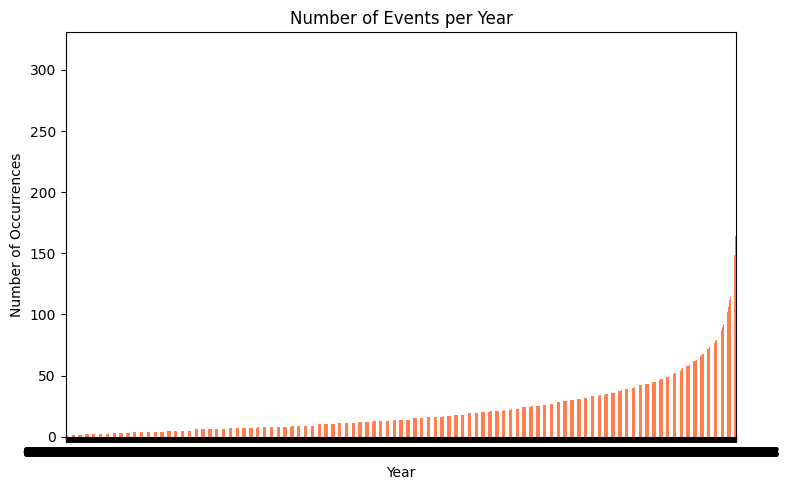

employed_krs
0000592640      1
0001175361      1
0001194609      1
0001194612      1
0001170830      1
             ... 
0000022460    161
0000028860    164
0000012483    166
0000026438    185
0000033455    315
Name: count, Length: 2781, dtype: int64

In [7]:
import matplotlib.pyplot as plt

# 3. Extract the year and count the occurrences
company_counts = people_krs['employed_krs'].value_counts()

# 4. Sort the counts by year (the index) for a chronological chart
company_counts = company_counts.sort_values()

# 5. Create the bar chart
plt.figure(figsize=(8, 5))
ax = company_counts.plot(
    kind='bar',
    color='coral',
    title='Number of Events per Year'
)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Occurrences")
plt.xticks(rotation=0) # Keep year labels horizontal
plt.tight_layout()
plt.show()

company_counts

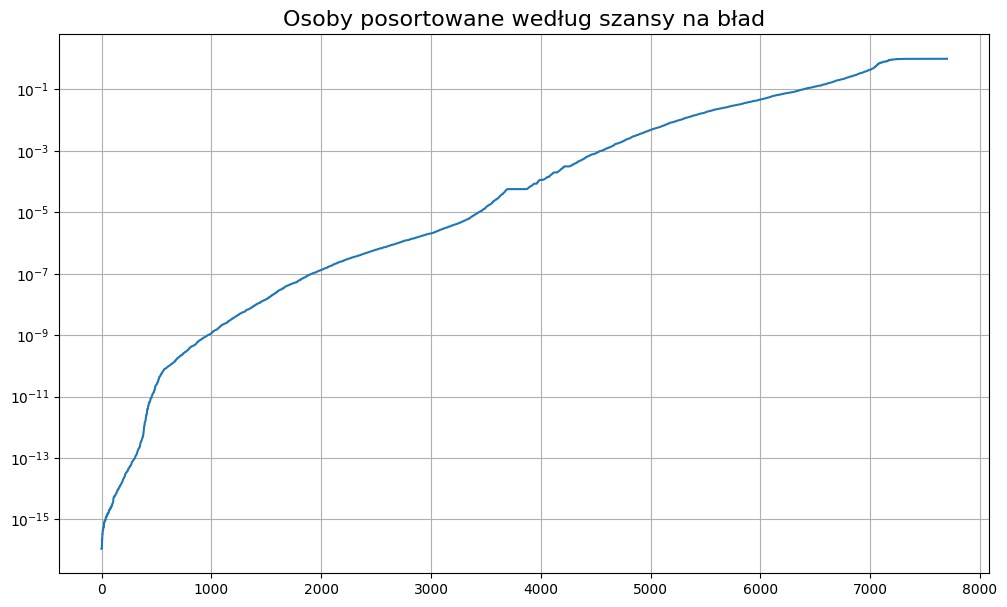

In [13]:
import matplotlib.pyplot as plt

unique_chance = 1 - matched_all["unique_chance"]
fig, ax = plt.subplots(figsize=(12, 7))
ax.grid(True)
ax.set_title('Osoby posortowane według szansy na bład', fontsize=16)
ax.set_yscale('log')
ax.plot(unique_chance)

In [9]:
import numpy as np

def calculate_poisson_binomial_history(probabilities: pd.Series) -> pd.DataFrame:
    """
    Calculates the evolving probability distribution of the number of successes
    at each step of including a new trial.

    Args:
        probabilities: A pandas Series where each value is the probability
                       of success (e.g., an error) for that trial.

    Returns:
        A pandas DataFrame where:
        - The index 'i' represents the number of people considered (from 0 to n).
        - The column 'k' represents the number of errors.
        - The value at [i, k] is the probability of having exactly k errors
          after considering the first i people.
    """
    n = len(probabilities)
    # Initialize a 2D array to store the history of distributions.
    # Dimensions are (n+1) rows for each step, (n+1) cols for k errors.
    history = np.zeros((n + 1, n + 1))
    history[0, 0] = 1.0  # P(0 errors | 0 people) = 1

    # Iterate from the 1st person to the nth person
    for i in range(1, n + 1):
        p = probabilities.iloc[i-1]  # Get the probability for the current person
        prev_probs = history[i-1, :] # Get the distribution from the previous step

        # Vectorized update, same as before
        term1 = prev_probs * (1 - p)
        term2 = np.roll(prev_probs, 1) * p
        term2[0] = 0

        history[i, :] = term1 + term2

    # Convert the result to a labeled DataFrame
    df = pd.DataFrame(history)
    df.index.name = "People Considered (i)"
    df.columns.name = "Number of Errors (k)"
    return df

binom_2d = calculate_poisson_binomial_history(unique_chance)

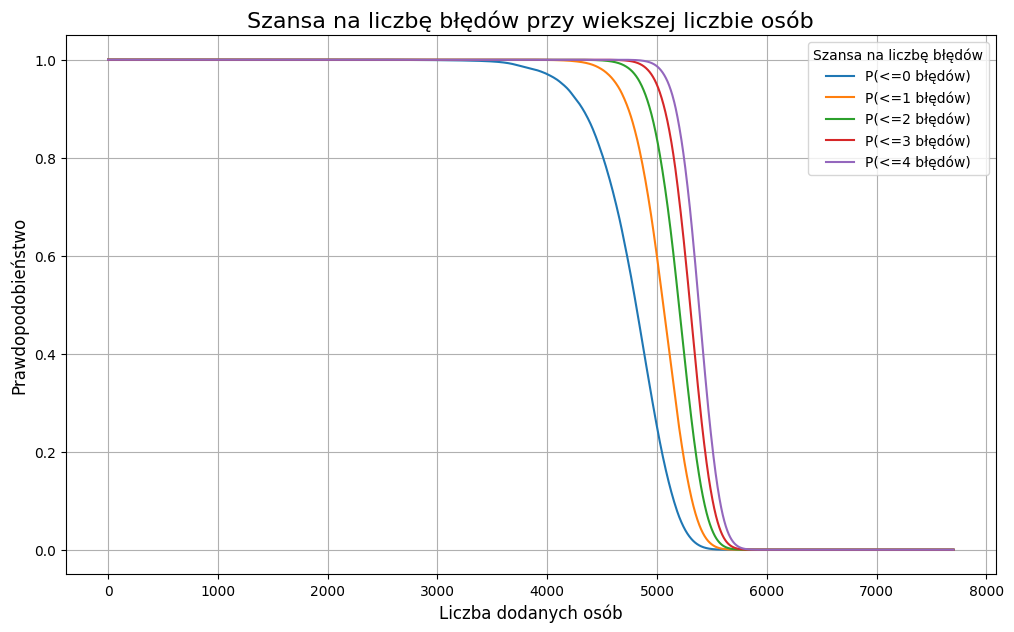

In [10]:
def show_distribution(df, label, num_errors_to_plot=10):
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Each is a column in our DataFrame
    for k in range(num_errors_to_plot):
        ax.plot(df.index, df[k], label=label.format(k=k))
    
    ax.set_title('Szansa na liczbę błędów przy wiekszej liczbie osób', fontsize=16)
    ax.set_xlabel('Liczba dodanych osób', fontsize=12)
    ax.set_ylabel('Prawdopodobieństwo', fontsize=12)
    ax.legend(title='Szansa na liczbę błędów')
    ax.grid(True)
    plt.show()
aggregated_error = binom_2d.cumsum(axis=1)
show_distribution(aggregated_error, 'P(<={k} błędów)', num_errors_to_plot=5)

In [11]:
treshold_count = len(aggregated_error[aggregated_error[0].gt(0.95)])
treshold_count, 1 / unique_chance[treshold_count]

(4141, np.float64(5016.637045184704))

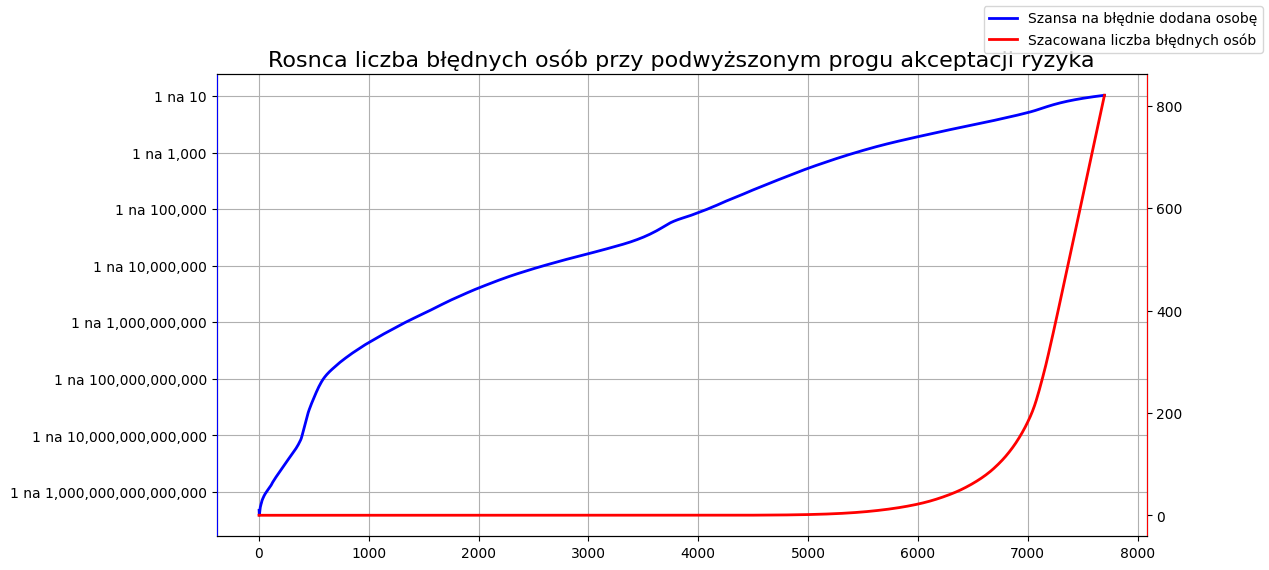

In [12]:
from matplotlib import ticker
import math

def reverse(x, pos):
    return f"1 na {math.ceil(1/x):,}"

def display_expected_error_count(unique_chance):
    expected_error_count = unique_chance.cumsum() # We use here linearity of expectation
    number_of_people = np.arange(len(expected_error_count))
    expected_error_rate = np.divide(expected_error_count, number_of_people)
    
    df = pd.DataFrame({
        "Expected number of errors": expected_error_count,
        "Expected error ratio": expected_error_rate,
    })
        
    fig, ax2 = plt.subplots(figsize=(12, 6))
    ax1 = ax2.twinx()
    ax1.plot(df.index, df["Expected number of errors"], 
            label='Szacowana liczba błędnych osób', color='red', linewidth=2)
    ax1.set_title('Rosnca liczba błędnych osób przy podwyższonym progu akceptacji ryzyka', fontsize=16)
    ax1.set_xlabel('Number of People Considered', fontsize=12)

    ax2.semilogy(df.index, df["Expected error ratio"], 
            label='Szansa na błędnie dodana osobę', color='blue', linewidth=2)
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(reverse))
    ax1.spines['left'].set_color('blue')
    ax1.spines['right'].set_color('red')

    
    ax2.grid(True)
    fig.legend()
    plt.show()

display_expected_error_count(unique_chance)